# gNMR Analysis

In [2]:
import os
import re
import glob
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import scipy
import scipy
from scipy.optimize import curve_fit
import matplotlib 
from pylab import *
from scipy import odr as odr
sns.set()



## ODR-Fit

In [3]:
def odrFit(xValues, xErrors, yValues, yErrors, fitFunction, startParams):
    fitModel = odr.Model(fitFunction)
    data = odr.RealData(xValues, yValues, sx=xErrors, sy=yErrors)
    fitter = odr.ODR(data, fitModel, beta0=startParams)
    out = fitter.run()
    popt = out.beta
    perr = out.sd_beta

    ndof = xValues.size - startParams.size
    for index in range(0, popt.size):
        print('p' + str(index) + ' = ' + str(round(popt[index], 3)) 
              + ' +- ' + str(round(perr[index], 3)))
    print('Chi^2 = ' + str(round(out.sum_square, 3)))
    print('red. Chi^2 = ' + str(round(out.res_var, 3)))
    print()
    return popt,perr,out

# Aufgabe 4 - Spin-Gitter Relaxationszeit

In [4]:
#import data

df_etabak_4 = pd.read_csv("../data/etabak_auf_4.csv",sep = ";",decimal=",")
df_soe_4 = pd.read_csv("../data/schweres_oel_auf_4.csv",sep=";",decimal=",")


#add errors
df_etabak_4["tau_err"] = 0.005
df_etabak_4["u_err"] = df_etabak_4["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

df_soe_4["tau_err"] = 0.005
df_soe_4["u_err"] = df_soe_4["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

In [5]:
df_etabak_4

,tau,delta_v,csv_datei,tau_err,u_err
0,0.005,3.5250,31,0.005,0.010
1,0.010,3.1125,32,0.005,0.010
2,0.015,2.7625,33,0.005,0.010
3,0.020,2.3750,34,0.005,0.010
4,0.025,2.0375,35,0.005,0.010
5,0.030,1.7375,36,0.005,0.010
6,0.035,1.4680,37,0.005,0.010
7,0.040,1.1812,38,0.005,0.010
8,0.045,0.9060,39,0.005,0.005
9,0.050,0.6430,40,0.005,0.005


p0 = 3.899 +- 0.007
p1 = 0.094 +- 0.001
Chi^2 = 4.654
red. Chi^2 = 0.233

Beta: [3.89911494 0.09359658]
Beta Std Error: [0.00706752 0.00069965]
Beta Covariance: [[2.14671231e-04 1.50521901e-05]
 [1.50521901e-05 2.10376641e-06]]
Residual Variance: 0.2326805001542827
Inverse Condition #: 0.17352852635616414
Reason(s) for Halting:
  Sum of squares convergence


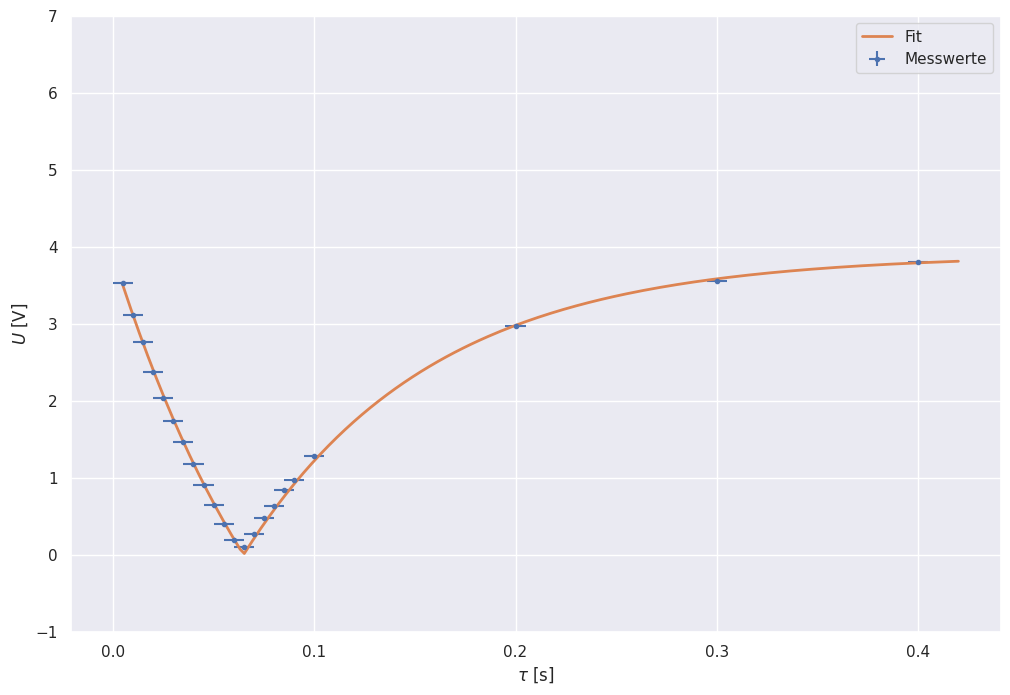

In [6]:


def fitFunc(params, x):
    m0, T1 = params
    return (m0*np.abs(1-2*(np.exp(-x/T1))))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_etabak_4["tau"].to_numpy()
xErr = df_etabak_4["tau_err"].to_numpy()
yData = df_etabak_4["delta_v"].to_numpy()
yErr = df_etabak_4["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.090])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.', label = "Messwerte")
"""plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$|1-2$\cdot$exp$\left(-\frac{\tau}{T_{1}}\right)$|, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{1}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))"""
plt.plot(x_fit, fit, lw=2, label='Fit')
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_4_etabak.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

p0 = 3.956 +- 0.013
p1 = 0.042 +- 0.002
Chi^2 = 43.657
red. Chi^2 = 3.638

Beta: [3.9555511  0.04244235]
Beta Std Error: [0.01345741 0.00214149]
Beta Covariance: [[4.97798443e-05 3.10812249e-06]
 [3.10812249e-06 1.26055137e-06]]
Residual Variance: 3.638058228511144
Inverse Condition #: 0.047981469401305835
Reason(s) for Halting:
  Sum of squares convergence


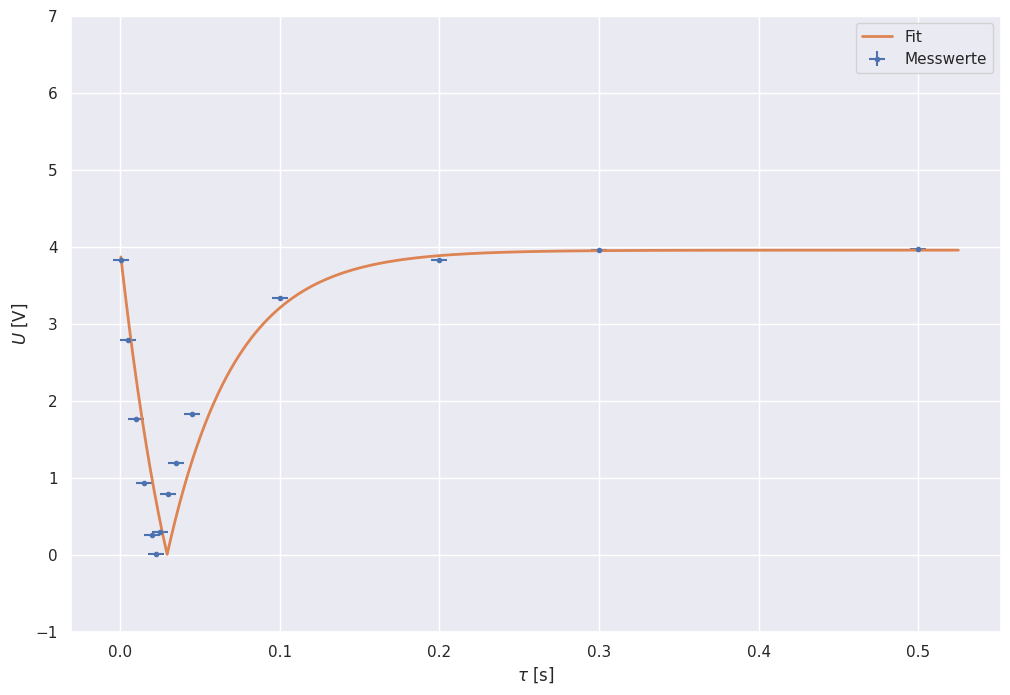

In [7]:


def fitFunc(params, x):
    m0, T1 = params
    return (m0*np.abs(1-2*(np.exp(-x/T1))))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_soe_4["tau"].to_numpy()
xErr = df_soe_4["tau_err"].to_numpy()
yData = df_soe_4["delta_v"].to_numpy()
yErr = df_soe_4["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.031])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.', label = "Messwerte")
plt.plot(x_fit, fit, lw=2, label='Fit')
"""plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$|1-2$\cdot$exp$\left(-\frac{\tau}{T_{1}}\right)$|, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{1}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))"""
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_4_soel.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

## Aufgabe 5 - Spin-Spin-Relaxationszeit mit Spin-Echo

In [8]:
#import data

df_etabak_5 = pd.read_csv("../data/etabak_auf_5.csv",sep = ";",decimal=",")
df_soe_5 = pd.read_csv("../data/schweres_oel_auf_5.csv",sep=";",decimal=",")


#add errors
df_etabak_5["tau_err"] = 0.0005
df_etabak_5["u_err"] = df_etabak_5["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

df_soe_5["tau_err"] = 0.0005
df_soe_5["u_err"] = df_soe_5["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

p0 = 4.682 +- 0.183
p1 = 0.048 +- 0.001
Chi^2 = 156.995
red. Chi^2 = 11.214

Beta: [4.68184218 0.04834722]
Beta Std Error: [0.18266472 0.00106766]
Beta Covariance: [[ 2.97543754e-03 -1.50414299e-05]
 [-1.50414299e-05  1.01650342e-07]]
Residual Variance: 11.213947242836767
Inverse Condition #: 0.14284138975493188
Reason(s) for Halting:
  Sum of squares convergence


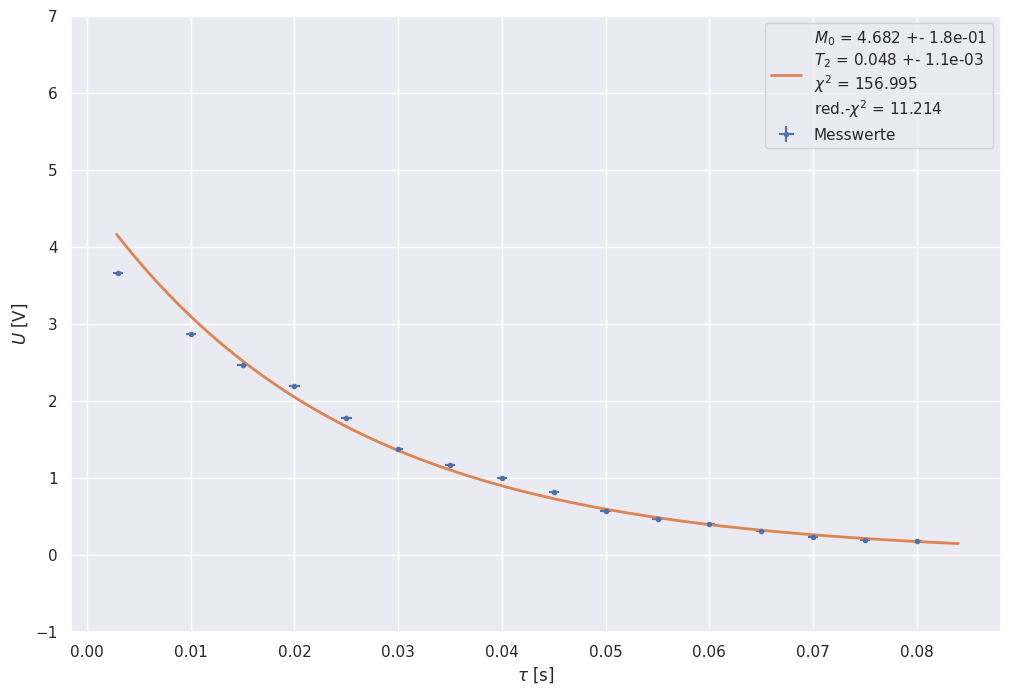

In [9]:


def fitFunc(params, x):
    m0, T2 = params
    return (m0*(np.exp(-(2*x)/T2)))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_etabak_5["tau"].to_numpy()
xErr = df_etabak_5["tau_err"].to_numpy()
yData = df_etabak_5["delta_v"].to_numpy()
yErr = df_etabak_5["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.065])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.', label = "Messwerte")
#plt.plot(x_fit, fit, lw=2, label='Fit')
plt.plot(x_fit, fit, lw=2,label=r'$M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0])
        + '\n'+ r'${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
        + '\n'+'$\chi^2$ = ' + str(round(fitResult.sum_square, 3))
        + '\n' + 'red.-$\chi^2$ = '+str(round(fitResult.res_var, 3)))
"""plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$$exp$\left(-\frac{2\tau}{T_{2}}\right)$, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))"""
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_5_etabak.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

p0 = 2.909 +- 0.389
p1 = 0.022 +- 0.001
Chi^2 = 178.51
red. Chi^2 = 22.314

Beta: [2.90915531 0.02210361]
Beta Std Error: [0.3892594  0.00145528]
Beta Covariance: [[ 6.79057081e-03 -2.06967919e-05]
 [-2.06967919e-05  9.49115817e-08]]
Residual Variance: 22.31371817977187
Inverse Condition #: 0.24855423317265354
Reason(s) for Halting:
  Sum of squares convergence


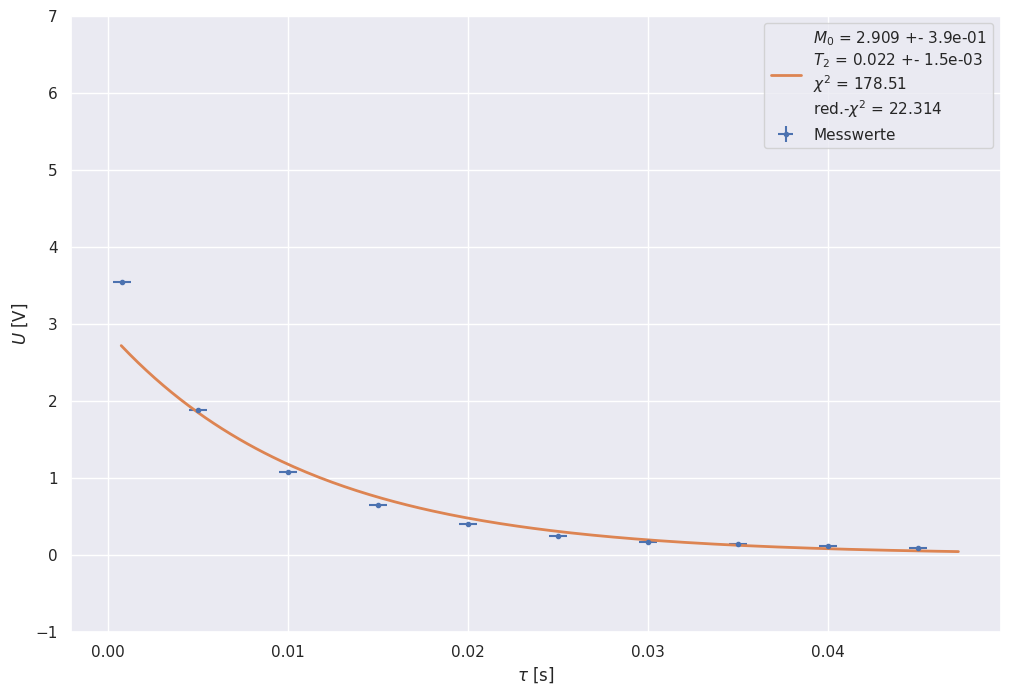

In [10]:


def fitFunc(params, x):
    m0, T2 = params
    return (m0*(np.exp(-(2*x)/T2)))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_soe_5["tau"].to_numpy()
xErr = df_soe_5["tau_err"].to_numpy()
yData = df_soe_5["delta_v"].to_numpy()
yErr = df_soe_5["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.025])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.', label = "Messwerte")
#plt.plot(x_fit, fit, lw=2, label='Fit')
plt.plot(x_fit, fit, lw=2,label=r'$M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0])
        + '\n'+ r'${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
        + '\n'+'$\chi^2$ = ' + str(round(fitResult.sum_square, 3))
        + '\n' + 'red.-$\chi^2$ = '+str(round(fitResult.res_var, 3)))
"""plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$$exp$\left(-\frac{2\tau}{T_{2}}\right)$, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))"""
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_5_soel.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

## Aufgabe 6 Car-Purcell vs Meiboom-Gill

In [11]:
#import data
import copy

dict_CPMG = {"soel_CP":29,"soel_MG":30,"etabak_CP":71,"etabak_MG":72}
dict_CPMG_dfs = {}

for k,v in dict_CPMG.items():
    df = pd.read_csv(f"../data/scope_files/scope_{v}.csv",sep=",",header = [0,1])
    df.dropna(inplace=True,axis=0)
    df.columns = df.columns.map('_'.join)
    df["tau_err"] = 0.0005
    df["u1_err"] = df["1_Volt"].apply(lambda x: 0.01 if x >= 1 else 0.005)
    df["u2_err"] = df["1_Volt"].apply(lambda x: 0.01 if x >= 1 else 0.005)

    df= df.loc[df["x-axis_second"]>=-0.03]
    df.reset_index(drop=True,inplace=True)

    dict_CPMG_dfs[k]= copy.deepcopy(df)



In [12]:
dict_CPMG_dfs["soel_CP"]

,x-axis_second,1_Volt,2_Volt,tau_err,u1_err,u2_err
0,-0.030,-0.002500,0.043500,0.0005,0.005,0.005
1,-0.029,-0.002500,0.052294,0.0005,0.005,0.005
2,-0.028,-0.006520,0.083701,0.0005,0.005,0.005
3,-0.027,-0.002500,0.083701,0.0005,0.005,0.005
4,-0.026,-0.002500,0.063601,0.0005,0.005,0.005
...,...,...,...,...,...,...
1025,0.995,-0.004510,0.063601,0.0005,0.005,0.005
1026,0.996,-0.010289,0.082445,0.0005,0.005,0.005
1027,0.997,-0.000490,0.062344,0.0005,0.005,0.005
1028,0.998,-0.010289,0.063601,0.0005,0.005,0.005


/tmp/ipykernel_4870/495443853.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp.append(dict_CPMG_dfs[art][["x-axis_second","2_Volt"]].loc[dict_CPMG_dfs[art]["2_Volt"]== dict_CPMG_dfs[art]["2_Volt"].max() ])


p0 = 2.538 +- 0.122
p1 = 0.021 +- 0.001
p2 = 0.11 +- 0.003
Chi^2 = 115.539
red. Chi^2 = 5.777

Beta: [2.53820935 0.02127087 0.10990739]
Beta Std Error: [0.12239824 0.000696   0.00282685]
Beta Covariance: [[ 2.59328892e-03 -1.08752176e-05  3.29634059e-06]
 [-1.08752176e-05  8.38526483e-08 -8.20264744e-08]
 [ 3.29634059e-06 -8.20264744e-08  1.38327076e-06]]
Residual Variance: 5.776961244436896
Inverse Condition #: 0.3042830179784441
Reason(s) for Halting:
  Sum of squares convergence


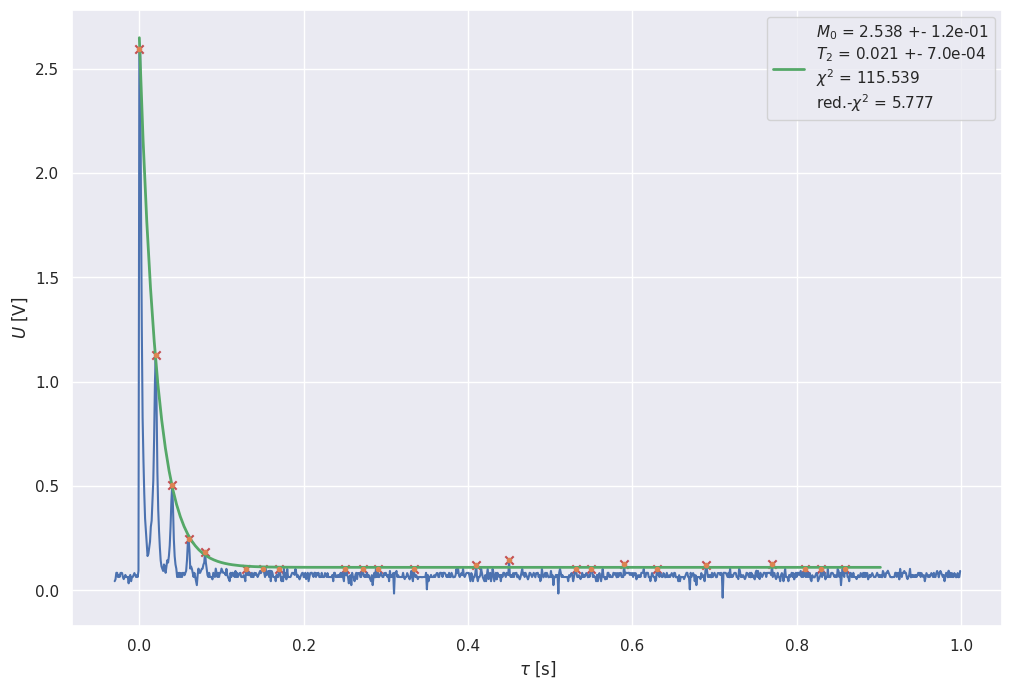

/tmp/ipykernel_4870/495443853.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp.append(dict_CPMG_dfs[art][["x-axis_second","2_Volt"]].loc[dict_CPMG_dfs[art]["2_Volt"]== dict_CPMG_dfs[art]["2_Volt"].max() ])


p0 = 2.61 +- 0.093
p1 = 0.021 +- 0.0
p2 = 0.102 +- 0.002
Chi^2 = 87.041
red. Chi^2 = 3.109

Beta: [2.60995098 0.02109071 0.10249315]
Beta Std Error: [0.09328934 0.00049768 0.00174177]
Beta Covariance: [[ 2.79960862e-03 -1.11394391e-05  3.35507936e-06]
 [-1.11394391e-05  7.96774413e-08 -6.43571303e-08]
 [ 3.35507936e-06 -6.43571303e-08  9.75916859e-07]]
Residual Variance: 3.1086131864727498
Inverse Condition #: 0.2885823169006001
Reason(s) for Halting:
  Sum of squares convergence


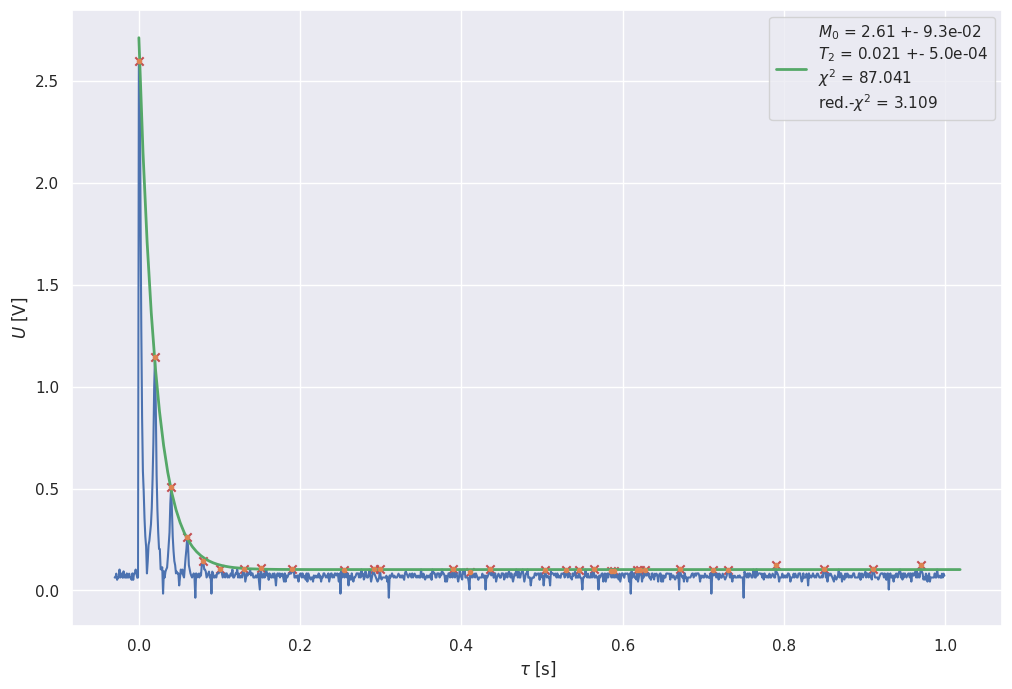

/tmp/ipykernel_4870/495443853.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp.append(dict_CPMG_dfs[art][["x-axis_second","2_Volt"]].loc[dict_CPMG_dfs[art]["2_Volt"]== dict_CPMG_dfs[art]["2_Volt"].max() ])


p0 = 3.796 +- 0.249
p1 = 0.039 +- 0.002
p2 = 0.153 +- 0.008
Chi^2 = 2497.939
red. Chi^2 = 65.735

Beta: [3.79631251 0.03882395 0.15292137]
Beta Std Error: [0.2487793  0.00183685 0.00837949]
Beta Covariance: [[ 9.41521343e-04 -5.04134958e-06  6.31047923e-06]
 [-5.04134958e-06  5.13275005e-08 -1.21196800e-07]
 [ 6.31047923e-06 -1.21196800e-07  1.06816075e-06]]
Residual Variance: 65.73524794099197
Inverse Condition #: 0.30284123203683666
Reason(s) for Halting:
  Sum of squares convergence


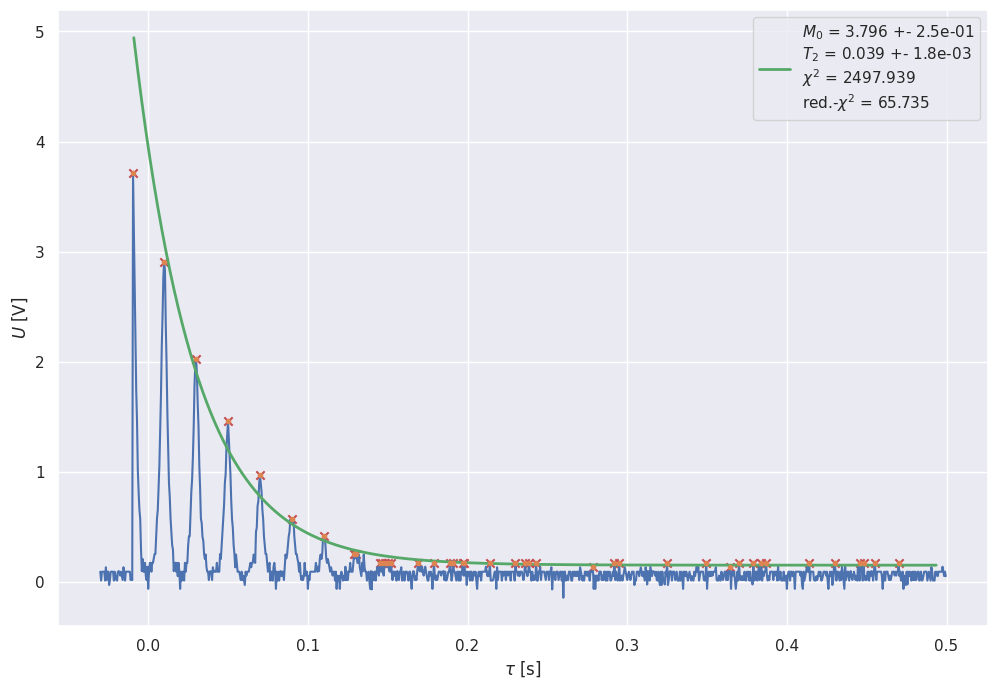

/tmp/ipykernel_4870/495443853.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_temp.append(dict_CPMG_dfs[art][["x-axis_second","2_Volt"]].loc[dict_CPMG_dfs[art]["2_Volt"]== dict_CPMG_dfs[art]["2_Volt"].max() ])


p0 = 3.575 +- 0.187
p1 = 0.045 +- 0.002
p2 = 0.143 +- 0.012
Chi^2 = 1245.609
red. Chi^2 = 56.619

Beta: [3.57510395 0.04451202 0.14312018]
Beta Std Error: [0.18723864 0.0020322  0.01163678]
Beta Covariance: [[ 6.19201554e-04 -4.66403418e-06  8.13046006e-06]
 [-4.66403418e-06  7.29413006e-08 -2.53923667e-07]
 [ 8.13046006e-06 -2.53923667e-07  2.39170073e-06]]
Residual Variance: 56.618573112001314
Inverse Condition #: 0.2153352888136544
Reason(s) for Halting:
  Sum of squares convergence


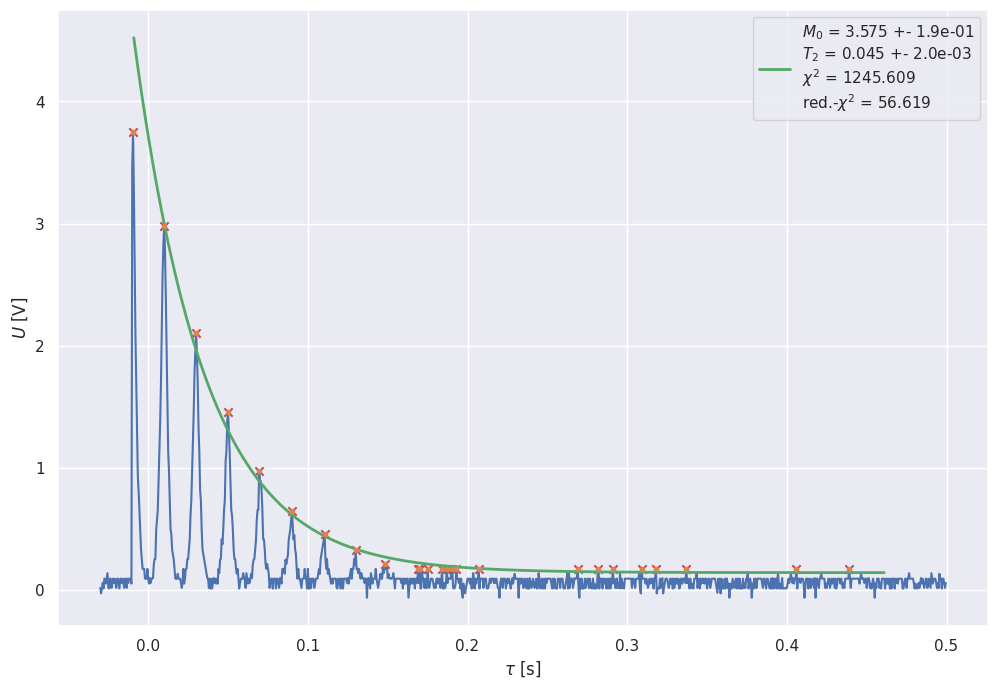

In [13]:
# get index values of peaks
dict_CPMG = {
    "soel_CP":0.06,
    "soel_MG":0.06,
    "etabak_CP":0.2,
    "etabak_MG":0.2
}
dict_peak_vals_CPMG = {}

for art in dict_CPMG_dfs.keys():
    if art in ["soel_CP","soel_MG"]:
        ref = "soel"
    else:
        ref = "etabak"
    fig1 = plt.figure(figsize=(12,8))

    plt.plot(dict_CPMG_dfs[art]["x-axis_second"], dict_CPMG_dfs[art]["2_Volt"])

    peaks, _dict = scipy.signal.find_peaks(x=dict_CPMG_dfs[art]["2_Volt"],width = 0.02,prominence=dict_CPMG[art])

    dict_temp = {}
    for xc in peaks:
        dict_temp[xc] = [dict_CPMG_dfs[art]["x-axis_second"][xc],dict_CPMG_dfs[art]["2_Volt"][xc]] 

    df_temp = pd.DataFrame.from_dict(data = dict_temp,orient="index",columns = ["zeit","spannung"])
    df_temp.append(dict_CPMG_dfs[art][["x-axis_second","2_Volt"]].loc[dict_CPMG_dfs[art]["2_Volt"]== dict_CPMG_dfs[art]["2_Volt"].max() ])
    df_temp["zeit_err"] = 0.0005
    df_temp["spannung_err"]= 0.005

    dict_peak_vals_CPMG[art] = dict_temp
    plt.scatter(x=df_temp["zeit"],y=df_temp["spannung"],color="r",marker="x")



    def fitFunc(params, x):
        m0, T2, c = params
        return (m0*(np.exp(-(x)/T2))+c)

    # Define the numpy arrays with the data points and the corresponding errors:
    xData = df_temp["zeit"].to_numpy()
    xErr = df_temp["zeit_err"].to_numpy()
    yData = df_temp["spannung"].to_numpy()
    yErr = df_temp["spannung_err"].to_numpy()

    # Set the start values for the parameters of our function, and call the fit routine. 
    # Remember: all arguments of our fitFunc are numpy arrays:

    startParameters = np.array([yData[0], 0.03,0.11])
    popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
    #print(popt)
    #print(perr)
    # Have a look to the fit result:
    fitResult.pprint()

    # Let's make a plot of the result:

    x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
    fit = fitFunc(popt, x_fit)

    # calculate the residuals in y direction
    residuals = fitResult.eps / yErr

    error_fmt = " +- {:.1e}"

    #fig1 = plt.figure(figsize=(12,8))
    plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
    """plt.plot(x_fit, fit, lw=2, label=
            r'Fit: M = $M_{0}\cdot$$exp$\left(-\frac{2\tau}{T_{2}}\right)$, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
            + r', ${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
            + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))"""
    plt.plot(x_fit, fit, lw=2,label=r'$M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0])
            + '\n'+ r'${T_{2}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
            + '\n'+'$\chi^2$ = ' + str(round(fitResult.sum_square, 3))
            + '\n' + 'red.-$\chi^2$ = '+str(round(fitResult.res_var, 3)))
    plt.xlabel(r"$\tau$ [s]")
    plt.ylabel(r"$U$ [V]")
    #plt.ylim(-1,7)
    plt.legend()
    plt.savefig(f"../images/aufgabe_6_{art}.jpg")
    #plt.title('Lebensdauer von Myonen')

    # fig2 = plt.figure(figsize=(12,2.5))
    # plot(xData, residuals,'or')
    # plt.xlabel(r"Zeitdelay [$\mu$s]")
    # plt.ylabel('Residuals')
    # plt.grid()
    #plt.savefig("../images/aufgabe_6_soel_mg.jpg")
    plt.show()

In [14]:
df_temp

,zeit,spannung,zeit_err,spannung_err
41,-0.0095,3.746864,0.0005,0.005
80,0.0100,2.983045,0.0005,0.005
120,0.0300,2.103648,0.0005,0.005
160,0.0500,1.455407,0.0005,0.005
199,0.0695,0.978020,0.0005,0.005
240,0.0900,0.651387,0.0005,0.005
281,0.1105,0.455407,0.0005,0.005
320,0.1300,0.329779,0.0005,0.005
357,0.1485,0.214201,0.0005,0.005
398,0.1690,0.174000,0.0005,0.005


In [15]:
dict_CPMG_dfs["soel_CP"]["x-axis_second"]

0      -0.030
1      -0.029
2      -0.028
3      -0.027
4      -0.026
        ...  
1025    0.995
1026    0.996
1027    0.997
1028    0.998
1029    0.999
Name: x-axis_second, Length: 1030, dtype: float64

## Chemische Verschiebung

In [16]:
#import data
import copy
dict_fluor = {"FC_43":76,"FC_70":77,"FC_770":78,"HT_770":79}
dict_fluor_dfs = {}

for k,v in dict_fluor.items():
    df = pd.read_csv(f"../data/scope_files/scope_{v}.csv",sep=",")
    df.dropna(inplace=True,axis=0)
    #df = df.stack().str.replace(',','.').unstack()
    #df["Volt_2"] = df["Volt_2"].apply(lambda x: x.str.replace(',','.'))
    df["Volt_2"]=df["Volt_2"].astype(float)
    dict_fluor_dfs[k]= copy.deepcopy(df)



In [17]:
dict_fluor_dfs["FC_43"]

,<,Volt_1,Hertz,Volt_2
2,-0.004990,0.003040,1510.0,0.001822
3,-0.004985,0.003040,1515.0,0.001822
4,-0.004980,0.002538,1520.0,0.001822
5,-0.004975,0.003040,1525.0,0.001822
6,-0.004970,0.003040,1530.0,0.001831
...,...,...,...,...
1995,0.004975,0.003040,11475.0,0.767016
1996,0.004980,0.003040,11480.0,0.767016
1997,0.004985,0.003040,11485.0,0.776782
1998,0.004990,0.003040,11490.0,0.776782


### Peaks identifizieren

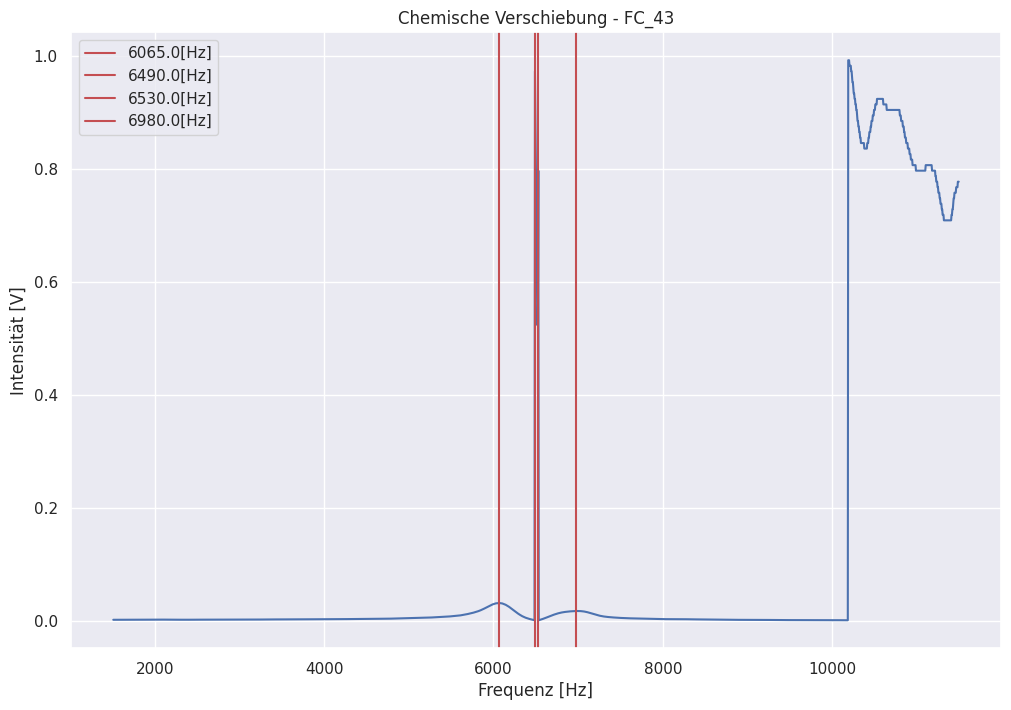

{'prominences': array([0.02973633, 0.97105355, 0.273437  , 0.0162207 ]), 'left_bases': array([  59,  995, 1002, 1005]), 'right_bases': array([ 995, 1005, 1005, 1697])}


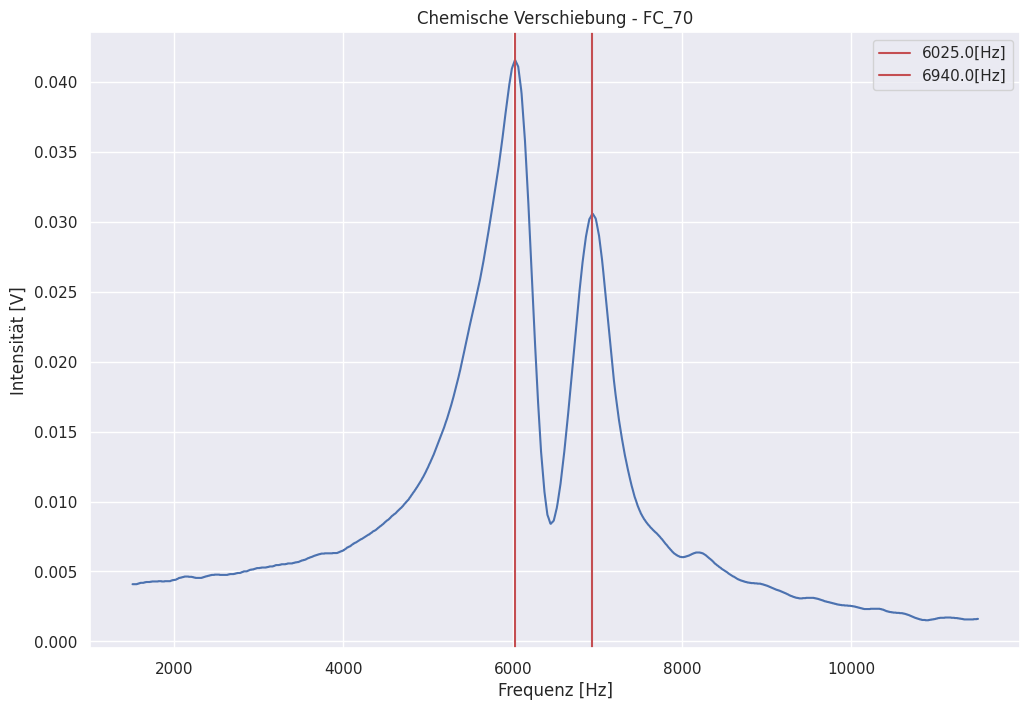

{'prominences': array([0.03746094, 0.02216797]), 'left_bases': array([ 10, 988]), 'right_bases': array([1697, 1697])}


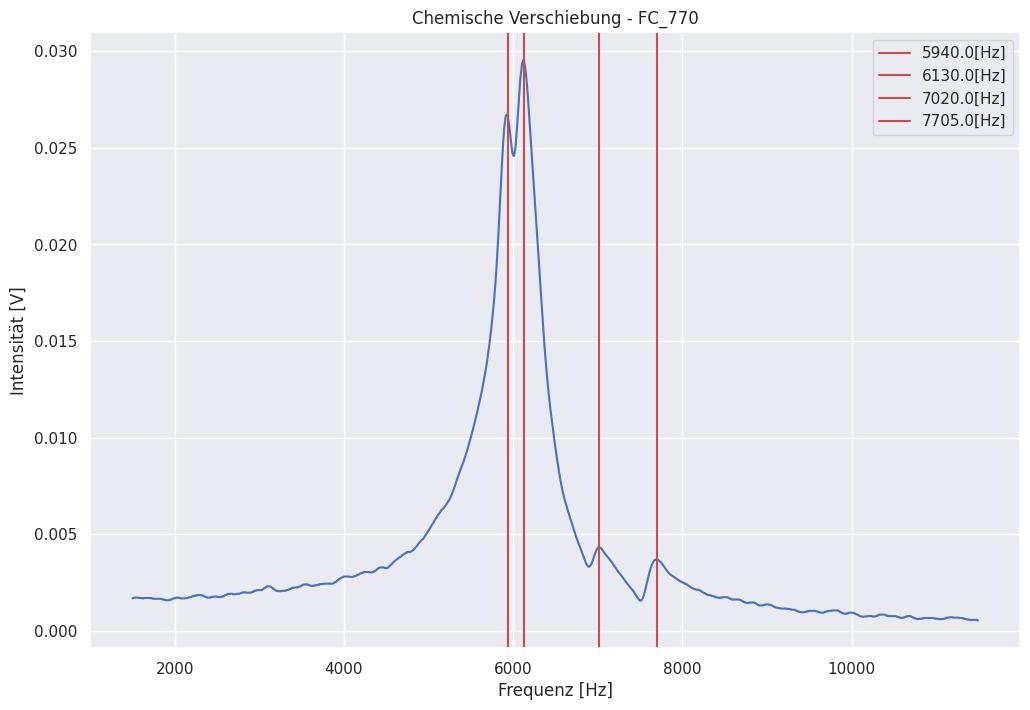

{'prominences': array([0.00214843, 0.02796875, 0.0009961 , 0.00212891]), 'left_bases': array([  87,   87, 1080, 1202]), 'right_bases': array([ 901, 1684, 1684, 1684])}


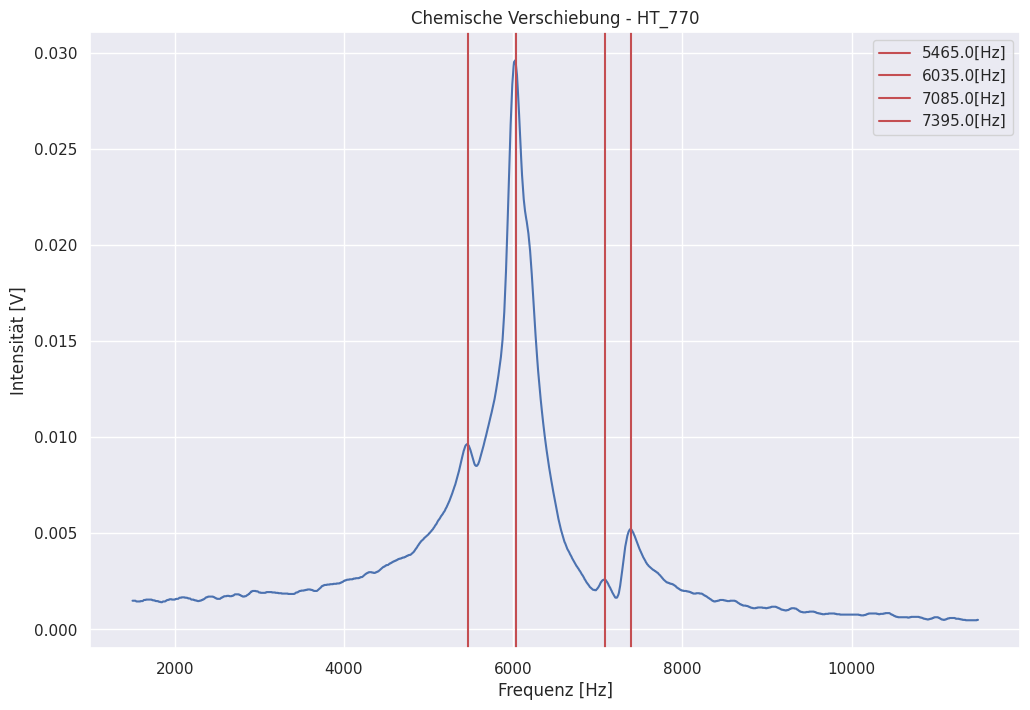

{'prominences': array([0.00113281, 0.0281836 , 0.00054688, 0.00355469]), 'left_bases': array([  70,   70, 1096, 1145]), 'right_bases': array([ 812, 1673, 1142, 1673])}


In [26]:
dict_xvals={
    "FC_43":0.003,
    "FC_70":0.003,
    "FC_770":0.0003,
    "HT_770":0.0003
}
dict_peak_vals = {}
for art in dict_fluor.keys():
    fig1 = plt.figure(figsize=(12,8))

    if art == "FC_43":
        xmax = 7000
        xmin=6000
    else:
        xmax=10000
        xmin=2000
    plt.plot(dict_fluor_dfs[art]["Hertz"], dict_fluor_dfs[art]["Volt_2"])
    #peaks, _ = scipy.signal.find_peaks(x=dict_fluor_dfs[art]["Volt_2"].loc[dict_fluor_dfs[art]["Hertz"]<=xmax],height=[0.6,1])
    peaks, _dict = scipy.signal.find_peaks(x=dict_fluor_dfs[art]["Volt_2"].loc[dict_fluor_dfs[art]["Hertz"]<=xmax],prominence = dict_xvals[art])
    
    #plt.plot(dict_fluor_dfs["FC_43"]["Hertz"][peaks+2], dict_fluor_dfs["FC_43"]["Volt_2"][peaks+2], "x")
    #plt.vlines(dict_fluor_dfs["FC_43"]["Hertz"][peaks+2], ymin=0,ymax=dict_fluor_dfs["FC_43"]["Volt_2"].max(),color="r")
    dict_temp = {}
    for xc in peaks:
        dict_temp[xc+2] = dict_fluor_dfs[art]["Hertz"][xc+2] 
        
        #height = dict_fluor_dfs[art]["Volt_2"][xc+2] * 30
        plt.axvline(x=dict_fluor_dfs[art]["Hertz"][xc+2],label=f'{dict_fluor_dfs[art]["Hertz"][xc+2]}[Hz]', color="r")
    dict_peak_vals[art] = dict_temp
    plt.xlabel("Frequenz [Hz]")
    plt.ylabel("Intensität [V]")
    if art == "FC_43":
        plt.xlim(6000,7500)
    plt.legend()
    plt.title(f'Chemische Verschiebung - {art}')

    """if art == "FC_43":
        plt.savefig(f"../images/aufgabe_7_{art}_alt.jpg")"""
    plt.savefig(f"../images/aufgabe_7_{art}.jpg")
    plt.show()
    print(_dict)

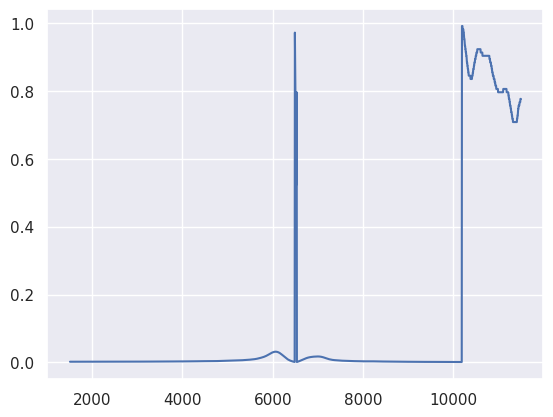

In [19]:
plt.plot(dict_fluor_dfs["FC_43"]["Hertz"],dict_fluor_dfs["FC_43"]["Volt_2"])
plt.xlabel("Frequenz [Hz]")
plt.ylabel("Intensität [V]")

In [20]:
scipy.signal.find_peaks(x=dict_fluor_dfs["FC_43"]["Volt_2"].loc[dict_fluor_dfs["FC_43"]["Hertz"]<=7000],height=0.6)

(array([ 996, 1004]), {'peak_heights': array([0.972094, 0.796313])})

In [21]:
dict_fluor_dfs["FC_43"].iloc[997]

<           -5.000000
Volt_1      -0.005000
Hertz     6495.000000
Volt_2       0.893969
Name: 999, dtype: float64

### Verschiebungen Berechnen

In [22]:
dict_peak_vals

{'FC_43': {998: 6490.0, 1006: 6530.0},
 'FC_70': {905: 6025.0, 1088: 6940.0},
 'FC_770': {888: 5940.0, 926: 6130.0, 1104: 7020.0, 1241: 7705.0},
 'HT_770': {793: 5465.0, 907: 6035.0, 1117: 7085.0, 1179: 7395.0}}